# Assignment 3
## Oxford-IIIT Pet Dataset
##### Transfer Learning (VGG16), Segmentation, U-Net (encoder & decoder), Augmentation  
### Notebook Content
<ol>
    <li><b>Load Dataset</b> - oxford_iiit_pet version 3.2.0</li>
    <li><b>Pre-Process</b> - <u>Resize</u> images and masks to <code>IMAGE_SIZE=224x224</code>, <u>rescale</u> images to [0, 1], and use <u>image augmentation</u> (flip & brightness)<br/>For low resources, use <code>IMAGE_SIZE=128x128</code></li>
    <li><b>Transfer Learning</b> - Pre-trained VGG16, using imagenet weights - Encoder in our U-Net</li>
    <li><b>Build a U-Net model</b> - Take the <u>pre-trained VGG16 as <i>Encoder</i></u>, and add <u>pix2pix upsample layers as <i>Decoder</i></u>, to construct a <b><code>U-Net</code></b> model</li>
    <li><b>Loss Function</b> - <code>SparseCategoricalCrossentropy</code> with metric <code>OneHotIoU</code></li>
    <li><b>Training</b> - Freeze all VGG16 layers, except first. Train the model using <b>Adam</b> optimizer with low learning rate. Use <code>BATCH_SIZE=32</code> (Or <code>BATCH_SIZE=16</code> if you are short on resources)</li>
    <li><b>Visualization</b> - See predictions from validation dataset and show diagrams for loss and IoU</li>
</ol>

### Assigned By
<b>Name:</b> Haim Adrian

---
## Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys

from tensorflow.keras import backend as K, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, Concatenate, LeakyReLU, Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import OneHotIoU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from scipy.ndimage import gaussian_filter1d

# I Don't care...
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

print(f'TensorFlow version: {tf.__version__}')


TensorFlow version: 2.8.0


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f'Running on {physical_devices[0].device_type}: {physical_devices[0].name}')
else:
    print('Running on CPU')

Running on GPU: /physical_device:GPU:0


## Load oxford_iiit_pet dataset, version 3.2.0

In [3]:
# Load the dataset
(ds_train, ds_test), ds_info = tfds.load('oxford_iiit_pet:3.2.0', split=['train', 'test'], with_info=True)

# Define some globals. 
# Specify batch and buffer sizes so we will not fail on ResourceExhaustedErrors.
# BUFFER_SIZE is lower than dataset size to avoid ResourceExhausted issues. We shuffle elements in the train dataset, randomly.
TRAIN_LENGTH = ds_info.splits['train'].num_examples
TEST_LENGTH = ds_info.splits['test'].num_examples
IMAGE_SHAPE = (224, 224)
EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 1000  
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // 5
CLASSES_COUNT = 3

print(ds_info.citation.title())
print('Image shape:', IMAGE_SHAPE)
print('Classes:', ds_info.features["label"].num_classes)
print('Species:', ds_info.features["species"].num_classes)
print('Train:', TRAIN_LENGTH)
print('Test:', TEST_LENGTH)

@Inproceedings{Parkhi12A,
  Author       = "Parkhi, O. M. And Vedaldi, A. And Zisserman, A. And Jawahar, C.~V.",
  Title        = "Cats And Dogs",
  Booktitle    = "Ieee Conference On Computer Vision And Pattern Recognition",
  Year         = "2012",
}
Image shape: (224, 224)
Classes: 37
Species: 2
Train: 3680
Test: 3669


## Visualize dataset
See how input samples look like

file_name  \
0                  b'Sphynx_158.jpg'   
1  b'english_cocker_spaniel_135.jpg'   
2       b'British_Shorthair_181.jpg'   
3                 b'Siamese_161.jpg'   

                                               image  label  \
0  [[[3, 3, 3], [5, 3, 4], [7, 5, 6], [4, 2, 3], ...     33   
1  [[[5, 9, 8], [3, 4, 0], [11, 24, 4], [36, 51, ...     12   
2  [[[44, 32, 6], [44, 34, 7], [44, 34, 7], [41, ...      9   
3  [[[108, 130, 117], [114, 133, 127], [108, 128,...     32   

                                   segmentation_mask  species  
0  [[[2], [2], [2], [2], [2], [2], [2], [2], [2],...        0  
1  [[[3], [3], [3], [3], [3], [3], [3], [3], [3],...        1  
2  [[[2], [2], [2], [2], [2], [2], [2], [2], [2],...        0  
3  [[[2], [2], [2], [2], [2], [2], [2], [2], [2],...        0
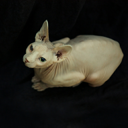
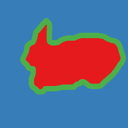
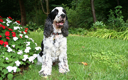
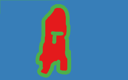
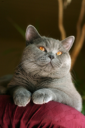
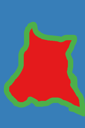
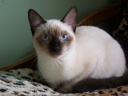
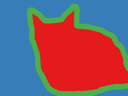

In [4]:
tfds.as_dataframe(ds_train.take(4), ds_info)

## Image Pre-Processing
sample is an oxford_iiit_pet data row.  
sample = FeaturesDict({  
&nbsp;&nbsp; '<b>file_name</b>': Text(shape=(), dtype=tf.string),  
&nbsp;&nbsp; '<b>image</b>': Image(shape=(None, None, 3), dtype=tf.uint8),  
&nbsp;&nbsp; '<b>label</b>': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),  
&nbsp;&nbsp; '<b>segmentation_mask</b>': Image(shape=(None, None, 1), dtype=tf.uint8),  
&nbsp;&nbsp; '<b>species</b>': ClassLabel(shape=(), dtype=tf.int64, num_classes=2)  
})

As part of pre-processing phase, we resize `sample['image']` to 224x224x3, to fit imagenet images. Then we convert it to `float32` type, and normalize to `[0, 1]` range.  
In addition, we resize `sample['segmentation_mask']` to match same shape, and decrease values by 1 so segmentation labels will be {0, 1, 2} instead of {1, 2, 3}.  
There is also a random augmentation so the model can learn to ignore irrelevant features: Flip (left-to-right) and brightness  

In [5]:
# Resize image and segmentation_mask to match our defined shape IMAGE_SHAPE
def resize(sample):
    return { 'image': tf.image.resize(sample['image'], IMAGE_SHAPE), 'segmentation_mask': tf.image.resize(sample['segmentation_mask'], IMAGE_SHAPE) }


# Simple augmentation: Randomly flip image horizontally, left-to-right, randomly play with brightness.
def rand_augment(sample):
    image, segmentation_mask = sample['image'], sample['segmentation_mask']
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        segmentation_mask = tf.image.flip_left_right(segmentation_mask)
    image = tf.image.random_brightness(image, max_delta=0.5)

    return { 'image': image, 'segmentation_mask': segmentation_mask }


# Rescale image values to [0, 1] range, and segmentation_mask values to {0, 1, 2}, to ease the 1-hot-iou metric calculation we have later on
def rescale(sample):
    image, segmentation_mask = sample['image'], sample['segmentation_mask']
    image = tf.cast(image, tf.float32) / 255.
    segmentation_mask = tf.cast(segmentation_mask, tf.int8) - 1
    return image, segmentation_mask


print('OK')

OK


In [6]:
# Use shuffle and repeat on train dataset, along with image augmentation, to produce "more" samples
# shuffle - Randomly shuffles the elements of this dataset. Use constant buffer size which is lower than dataset length, due to ReourceExhausted issues.
# repeat - Repeats train dataset so each original value is seen indefinitely amount of times 
ds_train_f64 = ds_train.map(lambda sample : rescale(rand_augment(resize(sample))), num_parallel_calls=tf.data.AUTOTUNE)\
                       .cache()\
                       .batch(BATCH_SIZE)\
                       .shuffle(BUFFER_SIZE)\
                       .repeat()\
                       .prefetch(tf.data.AUTOTUNE)

ds_test_f64 = ds_test.map(lambda sample : rescale(resize(sample)), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)


print('OK')

OK


## Transfer Learning
Use a modified U-Net model.  
U-Net is based on downsampler (encoder) and upsampler (decoder)  
To reduce amount of trainable parameters we use a pre-trained model as the downsampler part, and freeze its layers.  
Selected pre-trained model is <b>VGG16</b>.

In [7]:
# Have a short summary of the model because it is deep
def print_short_summary(title, a_model):
    trainable_count = int(np.sum([K.count_params(p) for p in a_model.trainable_weights]))
    non_trainable_count = int(np.sum([K.count_params(p) for p in a_model.non_trainable_weights]))

    print(title)
    print('-' * len(title))
    print('Name:', a_model.name)
    print('Depth:', len(a_model.layers))
    print(f'Total params: {trainable_count + non_trainable_count:,}')
    print(f'Trainable params: {trainable_count:,}')
    print(f'Non-trainable params: {non_trainable_count:,}')


print('OK')

OK


In [8]:
# An upsample layer, copied from pix2pix
def pix2pix_upsample(name, filters, kernel_size, strides, apply_dropout=True):
    initializer = tf.random_normal_initializer(0., 2e-2)

    result = Sequential(name=name)
    result.add(Conv2DTranspose(filters, kernel_size, strides=strides, padding='same', kernel_initializer=initializer))
    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(LeakyReLU(1e-1))
    return result


print('OK')

OK


#### Create a U-Net like model using a <u>pre-trained VGG16</u> model
Credits: Kaggle - https://www.kaggle.com/code/basu369victor/transferlearning-and-unet-to-segment-rocks-on-moon  
I modified it a little bit and used pix2pix upsampling

In [9]:
def unet_from_vgg16():
    pre_trained_vgg16 = VGG16(input_shape=IMAGE_SHAPE + (3,), include_top=False, weights="imagenet")
    pre_trained_vgg16.trainable = False  # Freeze its layers
    pre_trained_vgg16.get_layer('block1_conv1').trainable = True
    pre_trained_vgg16_output = pre_trained_vgg16.output
    inputs = pre_trained_vgg16.input
    
    filters_list = [256, 512, 512, 256, 128, 64]
    layers_to_use_for_skip = ['block5_conv3', 'block4_conv3', 'block3_conv3', 'block2_conv2', 'block1_conv2']
    
    up = pix2pix_upsample(f'upsample-for-{layers_to_use_for_skip[0]}-strides-2', filters=filters_list[0], kernel_size=3, strides=2)
    outputs = up(pre_trained_vgg16_output)
    skip = Concatenate(name=f'concatenate-{up.name}-with-{layers_to_use_for_skip[0]}')([outputs, pre_trained_vgg16.get_layer(layers_to_use_for_skip[0]).output])
    
    # First and last kernels are manually added
    for filters, layer_to_use_for_skip in zip(filters_list[1:-1], layers_to_use_for_skip[1:]):
        up = pix2pix_upsample(f'upsample-for-{layer_to_use_for_skip}-strides-1', filters=filters, kernel_size=3, strides=1)
        outputs = up(skip)
        
        up = pix2pix_upsample(f'upsample-for-{layer_to_use_for_skip}-strides-2', filters=filters, kernel_size=3, strides=2)
        outputs = up(outputs)
        
        skip = Concatenate(name=f'concatenate-{up.name}-with-{layer_to_use_for_skip}')([outputs, pre_trained_vgg16.get_layer(layer_to_use_for_skip).output])
    
    up = pix2pix_upsample(f'upsample-for-output-1', filters=filters_list[-1], kernel_size=3, strides=1)
    outputs = up(skip)
    
    up = pix2pix_upsample(f'upsample-for-output-2', filters=3, kernel_size=3, strides=1)
    outputs = up(outputs)
    
    return Model(name=f'unet-like-{pre_trained_vgg16.name}', inputs=inputs, outputs=outputs)


print('OK')

OK


#### Compile the U-Net like model and show a summary of it
<ul>
<li><b>Optimizer:</b> Adam</li>
<li><b>Loss:</b> SparseCategoricalCrossentropy, since we have got 3 classes {1, 2, 3} replaced with {0, 1, 2} to ease metrics (target_class_ids as range)</li>
<li><b>Metrics:</b> 1-hot Intersection Over Union</li>
</ul>

In [10]:
model = unet_from_vgg16()
model.compile(optimizer=Adam(learning_rate=2e-4), 
              loss=SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[OneHotIoU(num_classes=CLASSES_COUNT, target_class_ids=range(CLASSES_COUNT), name='1hot_iou')])

print('')
print_short_summary('Model (U-Net like model, consists of encoder (pre-trained VGG16) and decoder):', model)

print('\nFull Summary:')
model.summary()


Model (U-Net like model, consists of encoder (pre-trained VGG16) and decoder):
------------------------------------------------------------------------------
Name: unet-like-vgg16
Depth: 35
Total params: 31,947,599
Trainable params: 17,228,425
Non-trainable params: 14,719,174

Full Summary:
Model: "unet-like-vgg16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                       

#### Train and visualize prediction after every epoch

In [11]:
def show_prediction(prediction_list, figsize=(20, 10)):
    plt.figure(figsize=figsize)

    title = ['Actual Image', 'Ground Truth', 'Segmented Image (pred)']
    for i in range(len(prediction_list)):
        plt.subplot(1, len(prediction_list), i+1)
        plt.title(title[i], fontweight='bold', fontsize=16, color='tab:blue')
        plt.imshow(tf.keras.utils.array_to_img(prediction_list[i]))
    plt.show()


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(model, image, segmentation_mask, figsize=(20, 10)):
    pred_mask = model.predict(image)
    show_prediction([image[0], segmentation_mask[0], create_mask(pred_mask)], figsize)


print('OK')

OK


Prediction before training


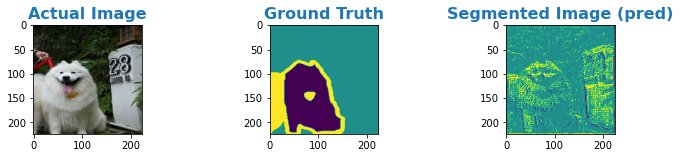

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.9025 - 1hot_iou: 0.1385
Prediction after epoch #1


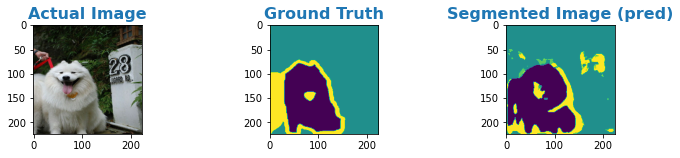

115/115 [==============================] - 105s 860ms/step - loss: 0.9025 - 1hot_iou: 0.1385 - val_loss: 0.6473 - val_1hot_iou: 0.0854
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.7672 - 1hot_iou: 0.1443
Prediction after epoch #2


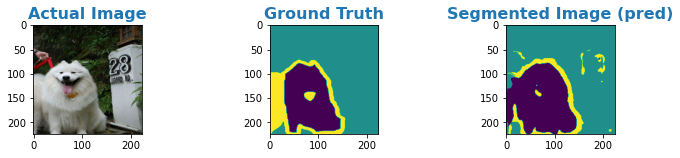

115/115 [==============================] - 98s 852ms/step - loss: 0.7672 - 1hot_iou: 0.1443 - val_loss: 0.6177 - val_1hot_iou: 0.0979
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.7429 - 1hot_iou: 0.1506
Prediction after epoch #3


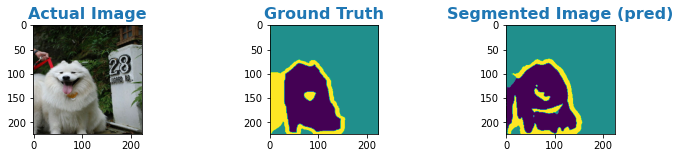

115/115 [==============================] - 98s 853ms/step - loss: 0.7429 - 1hot_iou: 0.1506 - val_loss: 0.6105 - val_1hot_iou: 0.0897
Epoch 4/100
115/115 [==============================] - ETA: 0s - loss: 0.7297 - 1hot_iou: 0.1542
Prediction after epoch #4


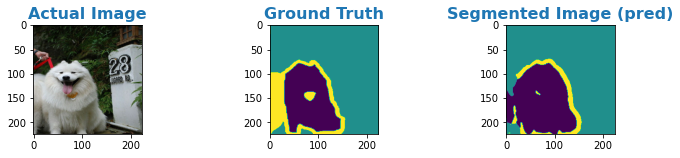

115/115 [==============================] - 98s 852ms/step - loss: 0.7297 - 1hot_iou: 0.1542 - val_loss: 0.5672 - val_1hot_iou: 0.0963
Epoch 5/100
115/115 [==============================] - ETA: 0s - loss: 0.7187 - 1hot_iou: 0.1554
Prediction after epoch #5


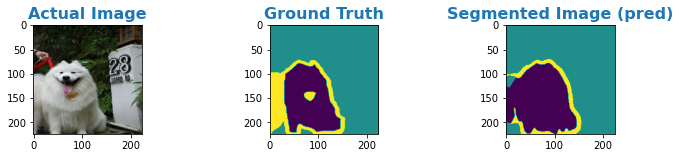

115/115 [==============================] - 98s 853ms/step - loss: 0.7187 - 1hot_iou: 0.1554 - val_loss: 0.5723 - val_1hot_iou: 0.0925
Epoch 6/100
115/115 [==============================] - ETA: 0s - loss: 0.7097 - 1hot_iou: 0.1565
Prediction after epoch #6


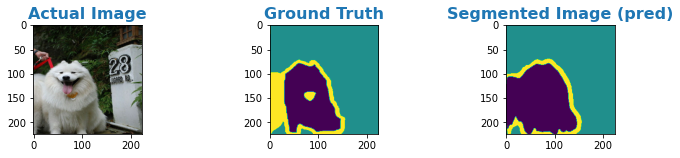

115/115 [==============================] - 98s 852ms/step - loss: 0.7097 - 1hot_iou: 0.1565 - val_loss: 0.5384 - val_1hot_iou: 0.0993
Epoch 7/100
115/115 [==============================] - ETA: 0s - loss: 0.7022 - 1hot_iou: 0.1568
Prediction after epoch #7


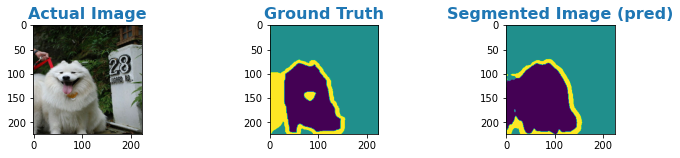

115/115 [==============================] - 98s 853ms/step - loss: 0.7022 - 1hot_iou: 0.1568 - val_loss: 0.5285 - val_1hot_iou: 0.0999
Epoch 8/100
115/115 [==============================] - ETA: 0s - loss: 0.6952 - 1hot_iou: 0.1571
Prediction after epoch #8


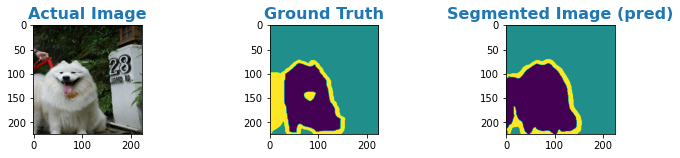

115/115 [==============================] - 98s 853ms/step - loss: 0.6952 - 1hot_iou: 0.1571 - val_loss: 0.5280 - val_1hot_iou: 0.0940
Epoch 9/100
115/115 [==============================] - ETA: 0s - loss: 0.6892 - 1hot_iou: 0.1571
Prediction after epoch #9


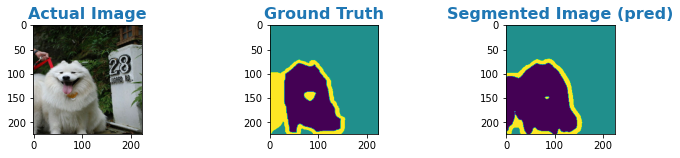

115/115 [==============================] - 98s 854ms/step - loss: 0.6892 - 1hot_iou: 0.1571 - val_loss: 0.5087 - val_1hot_iou: 0.1044
Epoch 10/100
115/115 [==============================] - ETA: 0s - loss: 0.6836 - 1hot_iou: 0.1572
Prediction after epoch #10


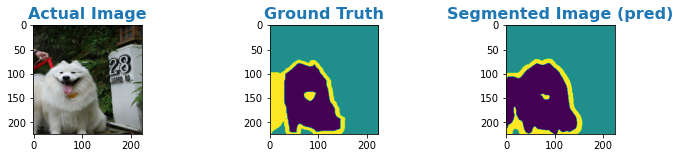

115/115 [==============================] - 98s 853ms/step - loss: 0.6836 - 1hot_iou: 0.1572 - val_loss: 0.4930 - val_1hot_iou: 0.1036
Epoch 11/100
115/115 [==============================] - ETA: 0s - loss: 0.6786 - 1hot_iou: 0.1571
Prediction after epoch #11


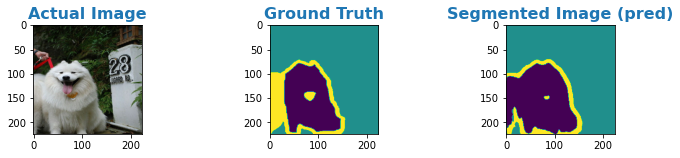

115/115 [==============================] - 98s 852ms/step - loss: 0.6786 - 1hot_iou: 0.1571 - val_loss: 0.5064 - val_1hot_iou: 0.0985
Epoch 12/100
115/115 [==============================] - ETA: 0s - loss: 0.6733 - 1hot_iou: 0.1572
Prediction after epoch #12


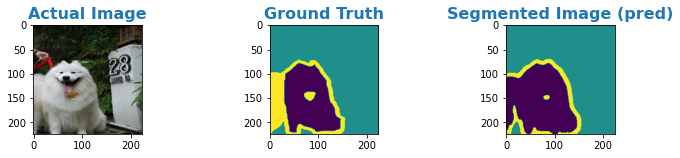

115/115 [==============================] - 98s 853ms/step - loss: 0.6733 - 1hot_iou: 0.1572 - val_loss: 0.4956 - val_1hot_iou: 0.0998
Epoch 13/100
115/115 [==============================] - ETA: 0s - loss: 0.6686 - 1hot_iou: 0.1570
Prediction after epoch #13


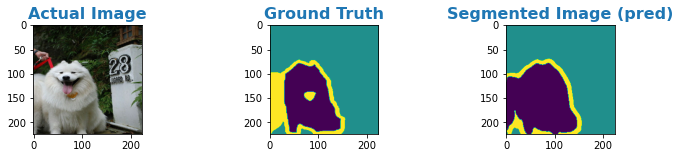

115/115 [==============================] - 98s 856ms/step - loss: 0.6686 - 1hot_iou: 0.1570 - val_loss: 0.4764 - val_1hot_iou: 0.1016
Epoch 14/100
115/115 [==============================] - ETA: 0s - loss: 0.6640 - 1hot_iou: 0.1571
Prediction after epoch #14


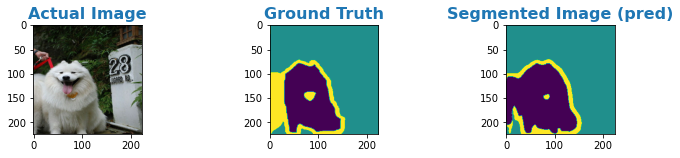

115/115 [==============================] - 98s 852ms/step - loss: 0.6640 - 1hot_iou: 0.1571 - val_loss: 0.4723 - val_1hot_iou: 0.0967
Epoch 15/100
115/115 [==============================] - ETA: 0s - loss: 0.6600 - 1hot_iou: 0.1570
Prediction after epoch #15


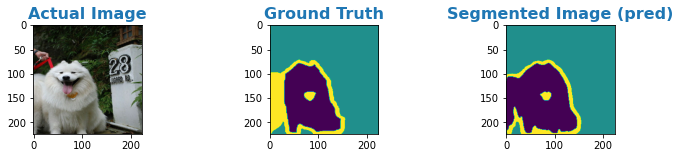

115/115 [==============================] - 98s 854ms/step - loss: 0.6600 - 1hot_iou: 0.1570 - val_loss: 0.4695 - val_1hot_iou: 0.0996
Epoch 16/100
115/115 [==============================] - ETA: 0s - loss: 0.6566 - 1hot_iou: 0.1569
Prediction after epoch #16


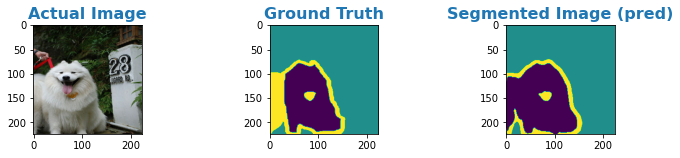

115/115 [==============================] - 98s 853ms/step - loss: 0.6566 - 1hot_iou: 0.1569 - val_loss: 0.4548 - val_1hot_iou: 0.1019
Epoch 17/100
115/115 [==============================] - ETA: 0s - loss: 0.6529 - 1hot_iou: 0.1570
Prediction after epoch #17


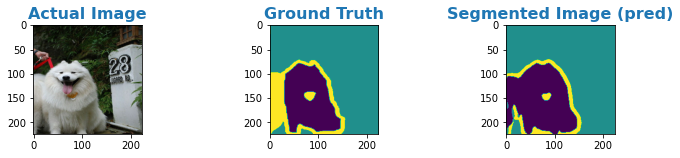

115/115 [==============================] - 98s 853ms/step - loss: 0.6529 - 1hot_iou: 0.1570 - val_loss: 0.4550 - val_1hot_iou: 0.1013
Epoch 18/100
115/115 [==============================] - ETA: 0s - loss: 0.6486 - 1hot_iou: 0.1569
Prediction after epoch #18


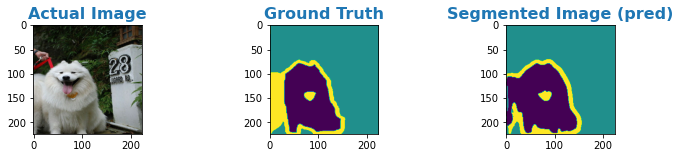

115/115 [==============================] - 98s 852ms/step - loss: 0.6486 - 1hot_iou: 0.1569 - val_loss: 0.4627 - val_1hot_iou: 0.0961
Epoch 19/100
115/115 [==============================] - ETA: 0s - loss: 0.6450 - 1hot_iou: 0.1568
Prediction after epoch #19


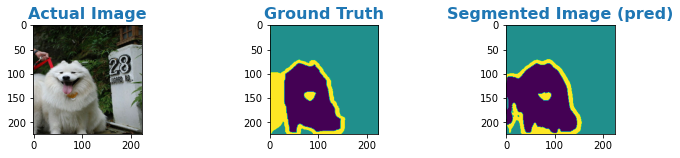

115/115 [==============================] - 98s 852ms/step - loss: 0.6450 - 1hot_iou: 0.1568 - val_loss: 0.4446 - val_1hot_iou: 0.1000
Epoch 20/100
115/115 [==============================] - ETA: 0s - loss: 0.6415 - 1hot_iou: 0.1568
Prediction after epoch #20


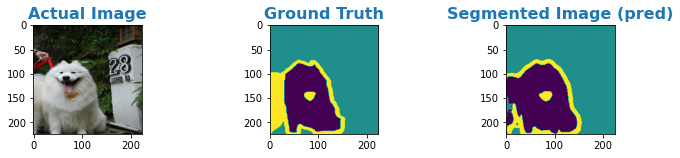

115/115 [==============================] - 98s 854ms/step - loss: 0.6415 - 1hot_iou: 0.1568 - val_loss: 0.4292 - val_1hot_iou: 0.0998
Epoch 21/100
115/115 [==============================] - ETA: 0s - loss: 0.6384 - 1hot_iou: 0.1568
Prediction after epoch #21


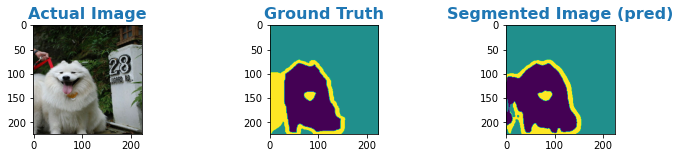

115/115 [==============================] - 98s 853ms/step - loss: 0.6384 - 1hot_iou: 0.1568 - val_loss: 0.4367 - val_1hot_iou: 0.0964
Epoch 22/100
115/115 [==============================] - ETA: 0s - loss: 0.6357 - 1hot_iou: 0.1568
Prediction after epoch #22


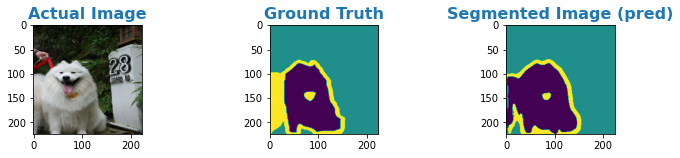

115/115 [==============================] - 98s 852ms/step - loss: 0.6357 - 1hot_iou: 0.1568 - val_loss: 0.4248 - val_1hot_iou: 0.0997
Epoch 23/100
115/115 [==============================] - ETA: 0s - loss: 0.6333 - 1hot_iou: 0.1568
Prediction after epoch #23


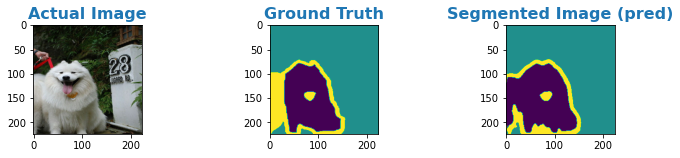

115/115 [==============================] - 98s 851ms/step - loss: 0.6333 - 1hot_iou: 0.1568 - val_loss: 0.4294 - val_1hot_iou: 0.0964
Epoch 24/100
115/115 [==============================] - ETA: 0s - loss: 0.6297 - 1hot_iou: 0.1568
Prediction after epoch #24


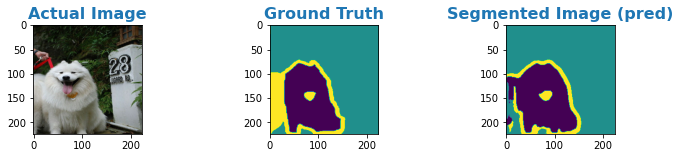

115/115 [==============================] - 98s 852ms/step - loss: 0.6297 - 1hot_iou: 0.1568 - val_loss: 0.4240 - val_1hot_iou: 0.0981
Epoch 25/100
115/115 [==============================] - ETA: 0s - loss: 0.6271 - 1hot_iou: 0.1568
Prediction after epoch #25


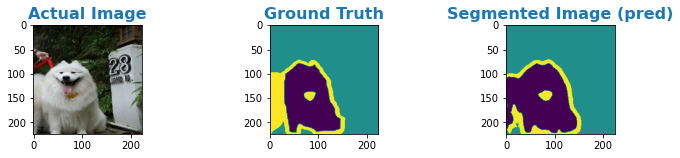

115/115 [==============================] - 98s 852ms/step - loss: 0.6271 - 1hot_iou: 0.1568 - val_loss: 0.3977 - val_1hot_iou: 0.1010
Epoch 26/100
115/115 [==============================] - ETA: 0s - loss: 0.6250 - 1hot_iou: 0.1567
Prediction after epoch #26


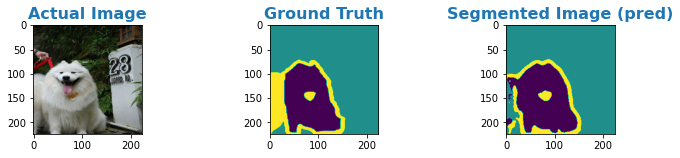

115/115 [==============================] - 98s 854ms/step - loss: 0.6250 - 1hot_iou: 0.1567 - val_loss: 0.4104 - val_1hot_iou: 0.0988
Epoch 27/100
115/115 [==============================] - ETA: 0s - loss: 0.6215 - 1hot_iou: 0.1567
Prediction after epoch #27


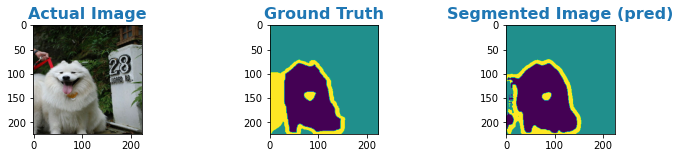

115/115 [==============================] - 98s 853ms/step - loss: 0.6215 - 1hot_iou: 0.1567 - val_loss: 0.4013 - val_1hot_iou: 0.0996
Epoch 28/100
115/115 [==============================] - ETA: 0s - loss: 0.6188 - 1hot_iou: 0.1568
Prediction after epoch #28


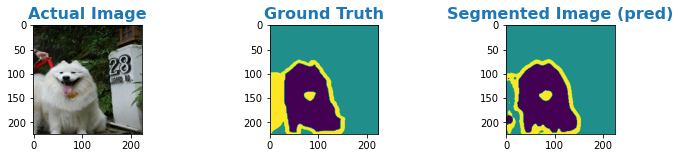

115/115 [==============================] - 98s 852ms/step - loss: 0.6188 - 1hot_iou: 0.1568 - val_loss: 0.4076 - val_1hot_iou: 0.0954
Epoch 29/100
115/115 [==============================] - ETA: 0s - loss: 0.6167 - 1hot_iou: 0.1568
Prediction after epoch #29


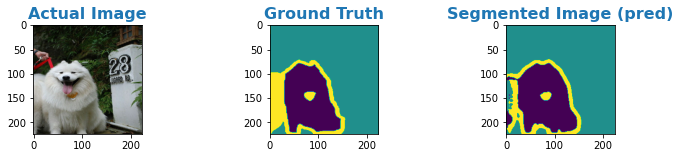

115/115 [==============================] - 98s 851ms/step - loss: 0.6167 - 1hot_iou: 0.1568 - val_loss: 0.3897 - val_1hot_iou: 0.0997
Epoch 30/100
115/115 [==============================] - ETA: 0s - loss: 0.6143 - 1hot_iou: 0.1567
Prediction after epoch #30


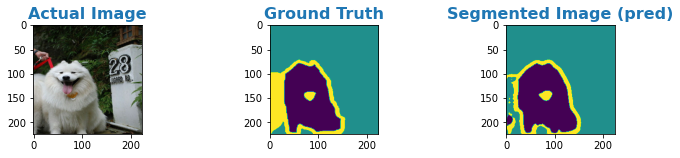

115/115 [==============================] - 98s 852ms/step - loss: 0.6143 - 1hot_iou: 0.1567 - val_loss: 0.3920 - val_1hot_iou: 0.0974
Epoch 31/100
115/115 [==============================] - ETA: 0s - loss: 0.6126 - 1hot_iou: 0.1569
Prediction after epoch #31


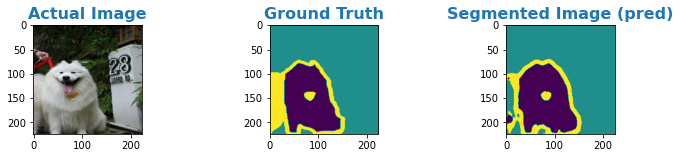

115/115 [==============================] - 98s 852ms/step - loss: 0.6126 - 1hot_iou: 0.1569 - val_loss: 0.3766 - val_1hot_iou: 0.1015
Epoch 32/100
115/115 [==============================] - ETA: 0s - loss: 0.6105 - 1hot_iou: 0.1568
Prediction after epoch #32


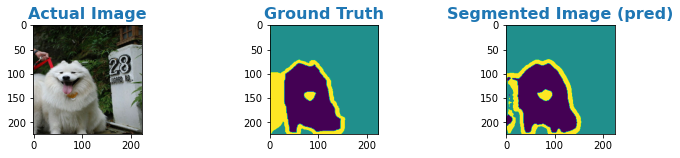

115/115 [==============================] - 98s 851ms/step - loss: 0.6105 - 1hot_iou: 0.1568 - val_loss: 0.3761 - val_1hot_iou: 0.0990
Epoch 33/100
115/115 [==============================] - ETA: 0s - loss: 0.6081 - 1hot_iou: 0.1568
Prediction after epoch #33


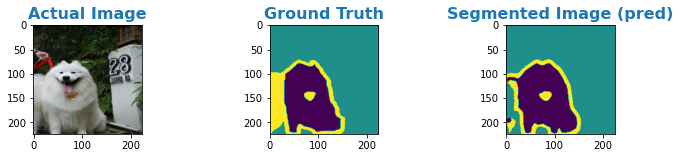

115/115 [==============================] - 98s 854ms/step - loss: 0.6081 - 1hot_iou: 0.1568 - val_loss: 0.3778 - val_1hot_iou: 0.1025
Epoch 34/100
115/115 [==============================] - ETA: 0s - loss: 0.6056 - 1hot_iou: 0.1568
Prediction after epoch #34


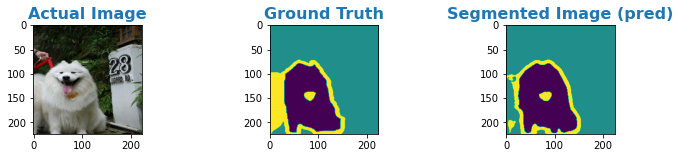

115/115 [==============================] - 98s 853ms/step - loss: 0.6056 - 1hot_iou: 0.1568 - val_loss: 0.3745 - val_1hot_iou: 0.0969
Epoch 35/100
115/115 [==============================] - ETA: 0s - loss: 0.6036 - 1hot_iou: 0.1569
Prediction after epoch #35


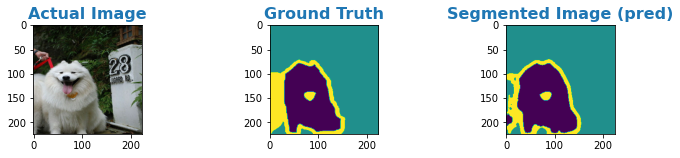

115/115 [==============================] - 98s 855ms/step - loss: 0.6036 - 1hot_iou: 0.1569 - val_loss: 0.3734 - val_1hot_iou: 0.1017
Epoch 36/100
115/115 [==============================] - ETA: 0s - loss: 0.6015 - 1hot_iou: 0.1568
Prediction after epoch #36


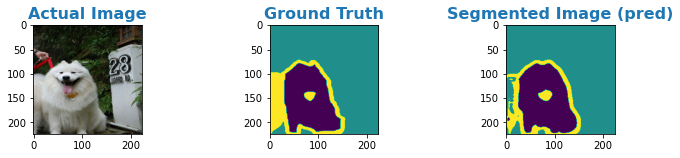

115/115 [==============================] - 98s 852ms/step - loss: 0.6015 - 1hot_iou: 0.1568 - val_loss: 0.3737 - val_1hot_iou: 0.0999
Epoch 37/100
115/115 [==============================] - ETA: 0s - loss: 0.6001 - 1hot_iou: 0.1569
Prediction after epoch #37


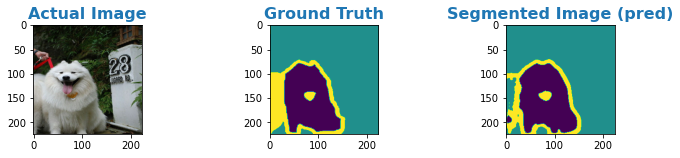

115/115 [==============================] - 98s 854ms/step - loss: 0.6001 - 1hot_iou: 0.1569 - val_loss: 0.3695 - val_1hot_iou: 0.0994
Epoch 38/100
115/115 [==============================] - ETA: 0s - loss: 0.5980 - 1hot_iou: 0.1569
Prediction after epoch #38


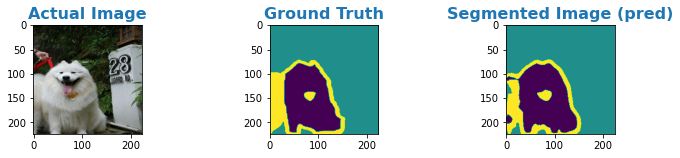

115/115 [==============================] - 98s 853ms/step - loss: 0.5980 - 1hot_iou: 0.1569 - val_loss: 0.3581 - val_1hot_iou: 0.1008
Epoch 39/100
115/115 [==============================] - ETA: 0s - loss: 0.5959 - 1hot_iou: 0.1569
Prediction after epoch #39


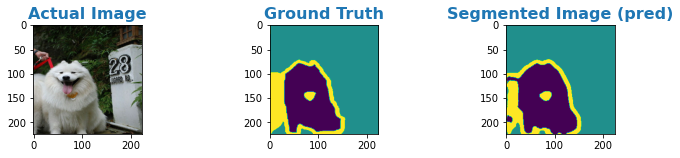

115/115 [==============================] - 98s 856ms/step - loss: 0.5959 - 1hot_iou: 0.1569 - val_loss: 0.3553 - val_1hot_iou: 0.1011
Epoch 40/100
115/115 [==============================] - ETA: 0s - loss: 0.5943 - 1hot_iou: 0.1570
Prediction after epoch #40


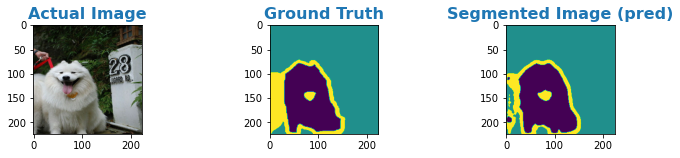

115/115 [==============================] - 98s 853ms/step - loss: 0.5943 - 1hot_iou: 0.1570 - val_loss: 0.3604 - val_1hot_iou: 0.1001
Epoch 41/100
115/115 [==============================] - ETA: 0s - loss: 0.5923 - 1hot_iou: 0.1570
Prediction after epoch #41


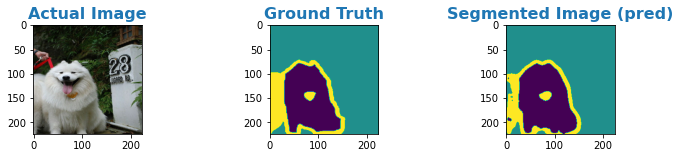

115/115 [==============================] - 98s 852ms/step - loss: 0.5923 - 1hot_iou: 0.1570 - val_loss: 0.3498 - val_1hot_iou: 0.0996
Epoch 42/100
115/115 [==============================] - ETA: 0s - loss: 0.5908 - 1hot_iou: 0.1570
Prediction after epoch #42


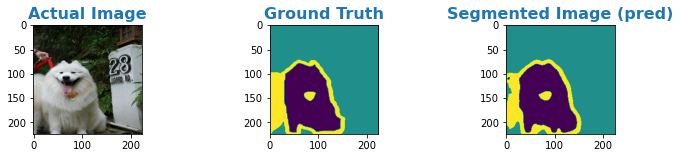

115/115 [==============================] - 98s 853ms/step - loss: 0.5908 - 1hot_iou: 0.1570 - val_loss: 0.3572 - val_1hot_iou: 0.0985
Epoch 43/100
115/115 [==============================] - ETA: 0s - loss: 0.5890 - 1hot_iou: 0.1570
Prediction after epoch #43


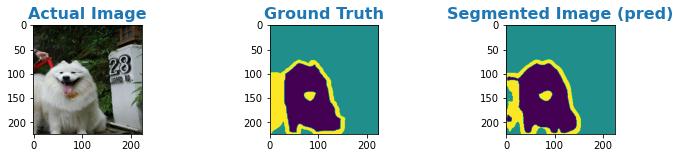

115/115 [==============================] - 98s 851ms/step - loss: 0.5890 - 1hot_iou: 0.1570 - val_loss: 0.3508 - val_1hot_iou: 0.0995
Epoch 44/100
115/115 [==============================] - ETA: 0s - loss: 0.5871 - 1hot_iou: 0.1571
Prediction after epoch #44


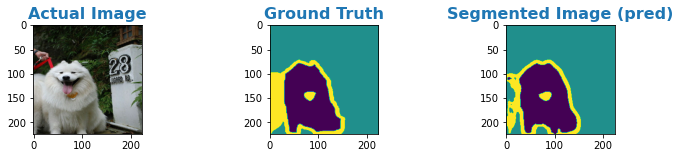

115/115 [==============================] - 98s 852ms/step - loss: 0.5871 - 1hot_iou: 0.1571 - val_loss: 0.3552 - val_1hot_iou: 0.0985
Epoch 45/100
115/115 [==============================] - ETA: 0s - loss: 0.5859 - 1hot_iou: 0.1571
Prediction after epoch #45


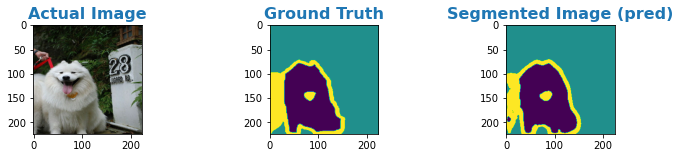

115/115 [==============================] - 98s 851ms/step - loss: 0.5859 - 1hot_iou: 0.1571 - val_loss: 0.3455 - val_1hot_iou: 0.0982
Epoch 46/100
115/115 [==============================] - ETA: 0s - loss: 0.5845 - 1hot_iou: 0.1571
Prediction after epoch #46


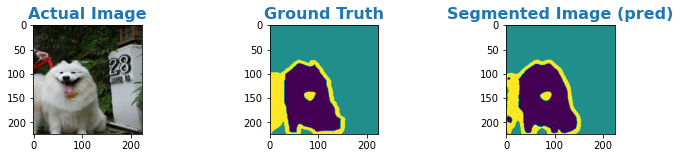

115/115 [==============================] - 98s 852ms/step - loss: 0.5845 - 1hot_iou: 0.1571 - val_loss: 0.3407 - val_1hot_iou: 0.1035
Epoch 47/100
115/115 [==============================] - ETA: 0s - loss: 0.5825 - 1hot_iou: 0.1571
Prediction after epoch #47


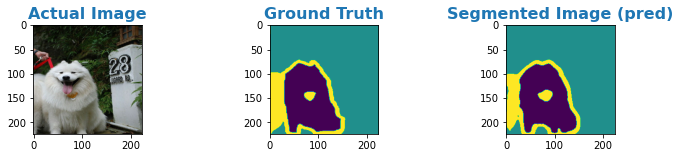

115/115 [==============================] - 98s 852ms/step - loss: 0.5825 - 1hot_iou: 0.1571 - val_loss: 0.3532 - val_1hot_iou: 0.0953
Epoch 48/100
115/115 [==============================] - ETA: 0s - loss: 0.5816 - 1hot_iou: 0.1571
Prediction after epoch #48


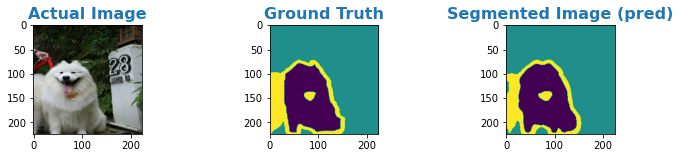

115/115 [==============================] - 98s 852ms/step - loss: 0.5816 - 1hot_iou: 0.1571 - val_loss: 0.3444 - val_1hot_iou: 0.0977
Epoch 49/100
115/115 [==============================] - ETA: 0s - loss: 0.5798 - 1hot_iou: 0.1571
Prediction after epoch #49


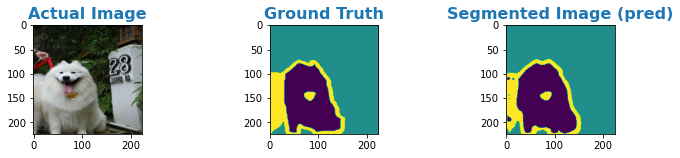

115/115 [==============================] - 98s 851ms/step - loss: 0.5798 - 1hot_iou: 0.1571 - val_loss: 0.3336 - val_1hot_iou: 0.1016
Epoch 50/100
115/115 [==============================] - ETA: 0s - loss: 0.5788 - 1hot_iou: 0.1572
Prediction after epoch #50


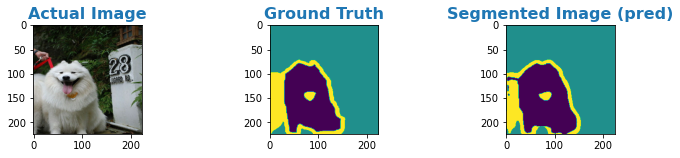

115/115 [==============================] - 98s 853ms/step - loss: 0.5788 - 1hot_iou: 0.1572 - val_loss: 0.3391 - val_1hot_iou: 0.1002
Epoch 51/100
115/115 [==============================] - ETA: 0s - loss: 0.5769 - 1hot_iou: 0.1572
Prediction after epoch #51


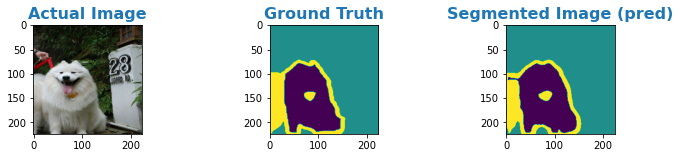

115/115 [==============================] - 98s 853ms/step - loss: 0.5769 - 1hot_iou: 0.1572 - val_loss: 0.3383 - val_1hot_iou: 0.0994
Epoch 52/100
115/115 [==============================] - ETA: 0s - loss: 0.5754 - 1hot_iou: 0.1572
Prediction after epoch #52


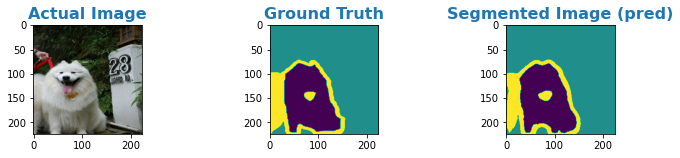

115/115 [==============================] - 98s 854ms/step - loss: 0.5754 - 1hot_iou: 0.1572 - val_loss: 0.3385 - val_1hot_iou: 0.0977
Epoch 53/100
115/115 [==============================] - ETA: 0s - loss: 0.5741 - 1hot_iou: 0.1572
Prediction after epoch #53


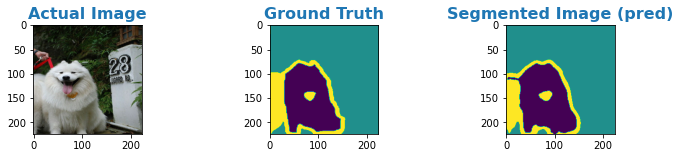

115/115 [==============================] - 98s 853ms/step - loss: 0.5741 - 1hot_iou: 0.1572 - val_loss: 0.3391 - val_1hot_iou: 0.0988
Epoch 54/100
115/115 [==============================] - ETA: 0s - loss: 0.5727 - 1hot_iou: 0.1574
Prediction after epoch #54


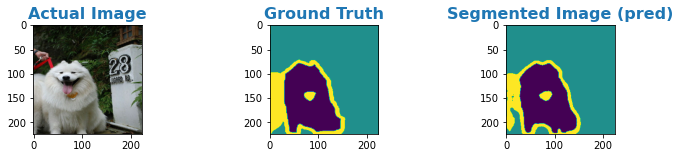

115/115 [==============================] - 98s 852ms/step - loss: 0.5727 - 1hot_iou: 0.1574 - val_loss: 0.3392 - val_1hot_iou: 0.0978
Epoch 55/100
115/115 [==============================] - ETA: 0s - loss: 0.5711 - 1hot_iou: 0.1573
Prediction after epoch #55


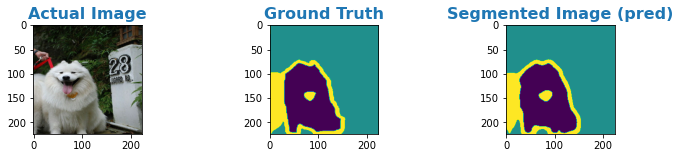

115/115 [==============================] - 98s 852ms/step - loss: 0.5711 - 1hot_iou: 0.1573 - val_loss: 0.3275 - val_1hot_iou: 0.0985
Epoch 56/100
115/115 [==============================] - ETA: 0s - loss: 0.5697 - 1hot_iou: 0.1573
Prediction after epoch #56


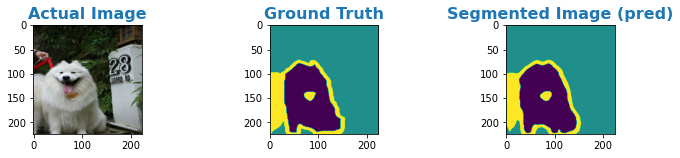

115/115 [==============================] - 98s 851ms/step - loss: 0.5697 - 1hot_iou: 0.1573 - val_loss: 0.3370 - val_1hot_iou: 0.0964
Epoch 57/100
115/115 [==============================] - ETA: 0s - loss: 0.5690 - 1hot_iou: 0.1573
Prediction after epoch #57


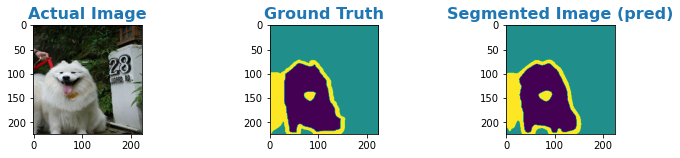

115/115 [==============================] - 98s 851ms/step - loss: 0.5690 - 1hot_iou: 0.1573 - val_loss: 0.3320 - val_1hot_iou: 0.0967
Epoch 58/100
115/115 [==============================] - ETA: 0s - loss: 0.5674 - 1hot_iou: 0.1574
Prediction after epoch #58


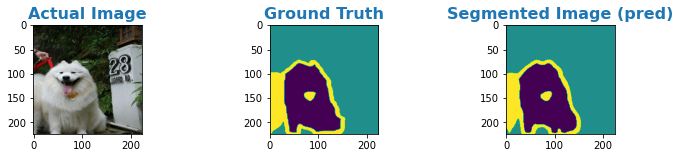

115/115 [==============================] - 98s 852ms/step - loss: 0.5674 - 1hot_iou: 0.1574 - val_loss: 0.3219 - val_1hot_iou: 0.0994
Epoch 59/100
115/115 [==============================] - ETA: 0s - loss: 0.5672 - 1hot_iou: 0.1574
Prediction after epoch #59


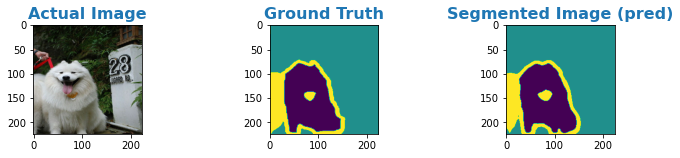

115/115 [==============================] - 98s 852ms/step - loss: 0.5672 - 1hot_iou: 0.1574 - val_loss: 0.3204 - val_1hot_iou: 0.0989
Epoch 60/100
115/115 [==============================] - ETA: 0s - loss: 0.5656 - 1hot_iou: 0.1573
Prediction after epoch #60


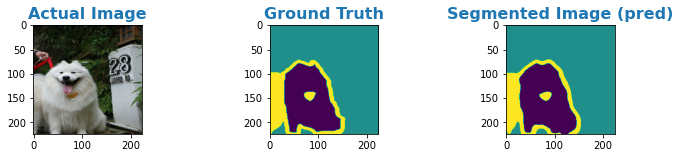

115/115 [==============================] - 98s 852ms/step - loss: 0.5656 - 1hot_iou: 0.1573 - val_loss: 0.3198 - val_1hot_iou: 0.1021
Epoch 61/100
115/115 [==============================] - ETA: 0s - loss: 0.5636 - 1hot_iou: 0.1575
Prediction after epoch #61


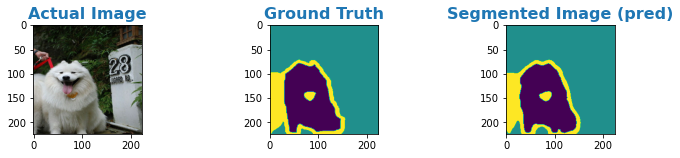

115/115 [==============================] - 98s 852ms/step - loss: 0.5636 - 1hot_iou: 0.1575 - val_loss: 0.3234 - val_1hot_iou: 0.0977
Epoch 62/100
115/115 [==============================] - ETA: 0s - loss: 0.5624 - 1hot_iou: 0.1575
Prediction after epoch #62


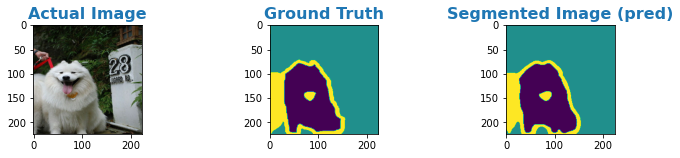

115/115 [==============================] - 98s 851ms/step - loss: 0.5624 - 1hot_iou: 0.1575 - val_loss: 0.3201 - val_1hot_iou: 0.1002
Epoch 63/100
115/115 [==============================] - ETA: 0s - loss: 0.5619 - 1hot_iou: 0.1574
Prediction after epoch #63


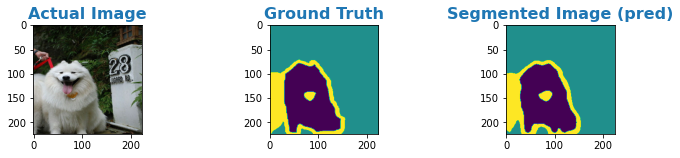

115/115 [==============================] - 98s 852ms/step - loss: 0.5619 - 1hot_iou: 0.1574 - val_loss: 0.3268 - val_1hot_iou: 0.0969
Epoch 64/100
115/115 [==============================] - ETA: 0s - loss: 0.5606 - 1hot_iou: 0.1575
Prediction after epoch #64


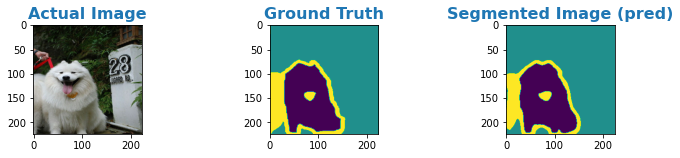

115/115 [==============================] - 98s 852ms/step - loss: 0.5606 - 1hot_iou: 0.1575 - val_loss: 0.3147 - val_1hot_iou: 0.0996
Epoch 65/100
115/115 [==============================] - ETA: 0s - loss: 0.5590 - 1hot_iou: 0.1575
Prediction after epoch #65


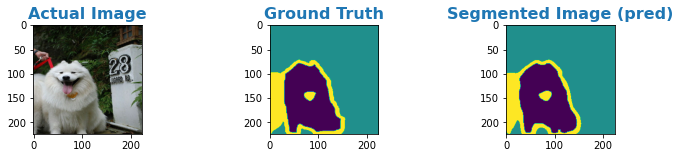

115/115 [==============================] - 98s 854ms/step - loss: 0.5590 - 1hot_iou: 0.1575 - val_loss: 0.3196 - val_1hot_iou: 0.0991
Epoch 66/100
115/115 [==============================] - ETA: 0s - loss: 0.5578 - 1hot_iou: 0.1575
Prediction after epoch #66


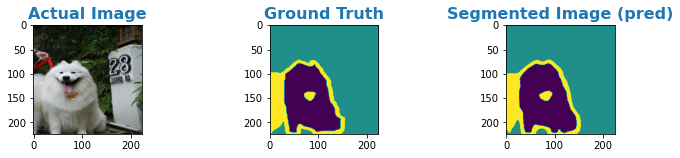

115/115 [==============================] - 98s 852ms/step - loss: 0.5578 - 1hot_iou: 0.1575 - val_loss: 0.3100 - val_1hot_iou: 0.0993
Epoch 67/100
115/115 [==============================] - ETA: 0s - loss: 0.5571 - 1hot_iou: 0.1576
Prediction after epoch #67


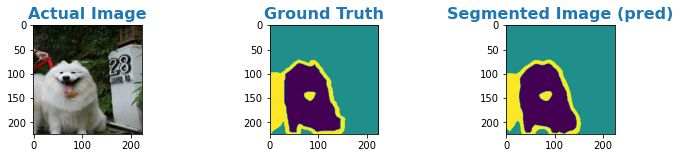

115/115 [==============================] - 98s 852ms/step - loss: 0.5571 - 1hot_iou: 0.1576 - val_loss: 0.3090 - val_1hot_iou: 0.0998
Epoch 68/100
115/115 [==============================] - ETA: 0s - loss: 0.5558 - 1hot_iou: 0.1575
Prediction after epoch #68


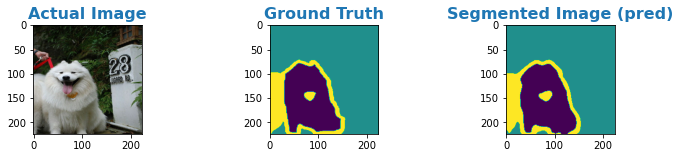

115/115 [==============================] - 98s 854ms/step - loss: 0.5558 - 1hot_iou: 0.1575 - val_loss: 0.3147 - val_1hot_iou: 0.0985
Epoch 69/100
115/115 [==============================] - ETA: 0s - loss: 0.5546 - 1hot_iou: 0.1576
Prediction after epoch #69


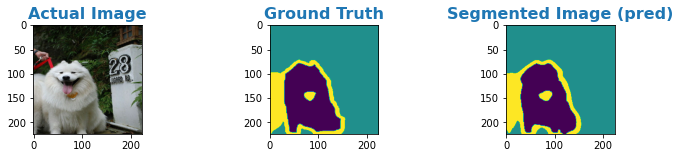

115/115 [==============================] - 98s 853ms/step - loss: 0.5546 - 1hot_iou: 0.1576 - val_loss: 0.3180 - val_1hot_iou: 0.0976
Epoch 70/100
115/115 [==============================] - ETA: 0s - loss: 0.5541 - 1hot_iou: 0.1575
Prediction after epoch #70


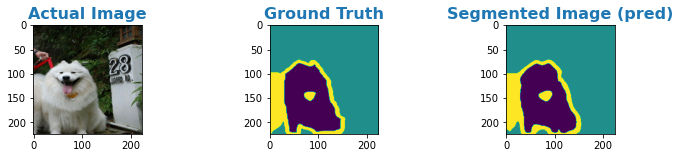

115/115 [==============================] - 98s 853ms/step - loss: 0.5541 - 1hot_iou: 0.1575 - val_loss: 0.3064 - val_1hot_iou: 0.1003
Epoch 71/100
115/115 [==============================] - ETA: 0s - loss: 0.5532 - 1hot_iou: 0.1576
Prediction after epoch #71


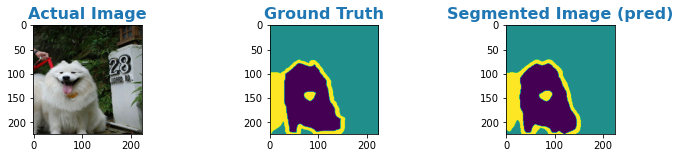

115/115 [==============================] - 98s 852ms/step - loss: 0.5532 - 1hot_iou: 0.1576 - val_loss: 0.3082 - val_1hot_iou: 0.0986
Epoch 72/100
115/115 [==============================] - ETA: 0s - loss: 0.5511 - 1hot_iou: 0.1576
Prediction after epoch #72


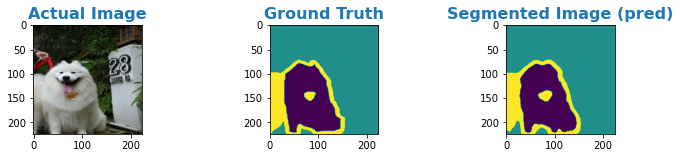

115/115 [==============================] - 98s 853ms/step - loss: 0.5511 - 1hot_iou: 0.1576 - val_loss: 0.3031 - val_1hot_iou: 0.0972
Epoch 73/100
115/115 [==============================] - ETA: 0s - loss: 0.5499 - 1hot_iou: 0.1576
Prediction after epoch #73


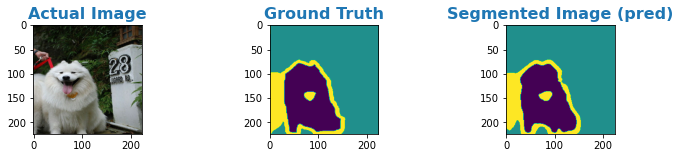

115/115 [==============================] - 98s 853ms/step - loss: 0.5499 - 1hot_iou: 0.1576 - val_loss: 0.3143 - val_1hot_iou: 0.0963
Epoch 74/100
115/115 [==============================] - ETA: 0s - loss: 0.5491 - 1hot_iou: 0.1576
Prediction after epoch #74


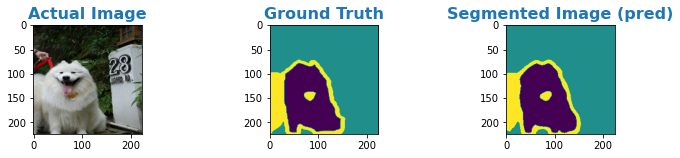

115/115 [==============================] - 98s 852ms/step - loss: 0.5491 - 1hot_iou: 0.1576 - val_loss: 0.3055 - val_1hot_iou: 0.0997
Epoch 75/100
115/115 [==============================] - ETA: 0s - loss: 0.5477 - 1hot_iou: 0.1576
Prediction after epoch #75


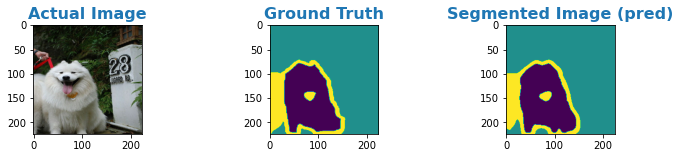

115/115 [==============================] - 98s 853ms/step - loss: 0.5477 - 1hot_iou: 0.1576 - val_loss: 0.3091 - val_1hot_iou: 0.0997
Epoch 76/100
115/115 [==============================] - ETA: 0s - loss: 0.5466 - 1hot_iou: 0.1577
Prediction after epoch #76


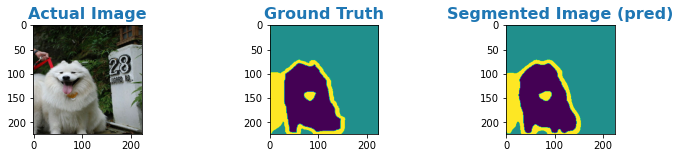

115/115 [==============================] - 98s 852ms/step - loss: 0.5466 - 1hot_iou: 0.1577 - val_loss: 0.2985 - val_1hot_iou: 0.0990
Epoch 77/100
115/115 [==============================] - ETA: 0s - loss: 0.5456 - 1hot_iou: 0.1577
Prediction after epoch #77


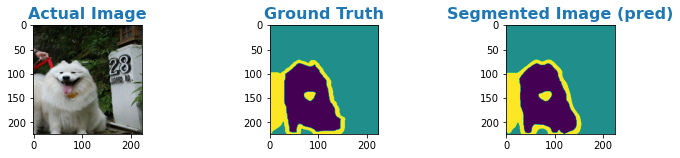

115/115 [==============================] - 98s 853ms/step - loss: 0.5456 - 1hot_iou: 0.1577 - val_loss: 0.3022 - val_1hot_iou: 0.1001
Epoch 78/100
115/115 [==============================] - ETA: 0s - loss: 0.5446 - 1hot_iou: 0.1577
Prediction after epoch #78


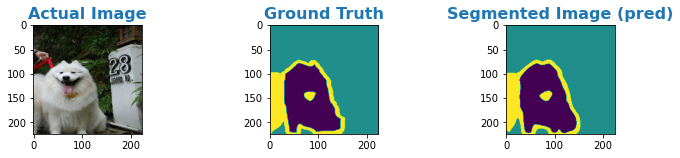

115/115 [==============================] - 98s 855ms/step - loss: 0.5446 - 1hot_iou: 0.1577 - val_loss: 0.3020 - val_1hot_iou: 0.1000
Epoch 79/100
115/115 [==============================] - ETA: 0s - loss: 0.5434 - 1hot_iou: 0.1577
Prediction after epoch #79


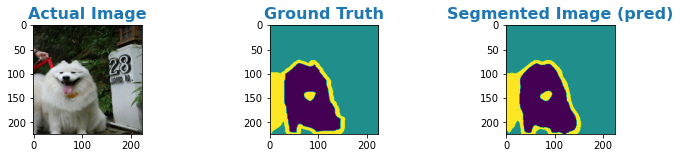

115/115 [==============================] - 98s 852ms/step - loss: 0.5434 - 1hot_iou: 0.1577 - val_loss: 0.2985 - val_1hot_iou: 0.1004
Epoch 80/100
115/115 [==============================] - ETA: 0s - loss: 0.5427 - 1hot_iou: 0.1577
Prediction after epoch #80


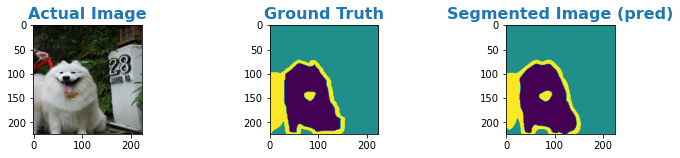

115/115 [==============================] - 98s 853ms/step - loss: 0.5427 - 1hot_iou: 0.1577 - val_loss: 0.3056 - val_1hot_iou: 0.0972
Epoch 81/100
115/115 [==============================] - ETA: 0s - loss: 0.5427 - 1hot_iou: 0.1577
Prediction after epoch #81


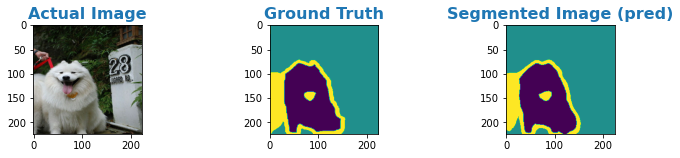

115/115 [==============================] - 98s 852ms/step - loss: 0.5427 - 1hot_iou: 0.1577 - val_loss: 0.3002 - val_1hot_iou: 0.1021
Epoch 82/100
115/115 [==============================] - ETA: 0s - loss: 0.5410 - 1hot_iou: 0.1577
Prediction after epoch #82


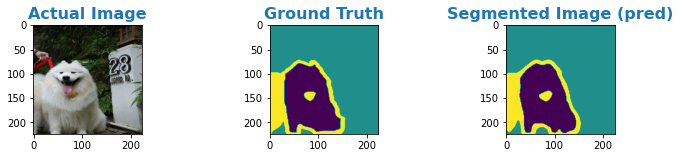

115/115 [==============================] - 98s 852ms/step - loss: 0.5410 - 1hot_iou: 0.1577 - val_loss: 0.2959 - val_1hot_iou: 0.1005
Epoch 83/100
115/115 [==============================] - ETA: 0s - loss: 0.5397 - 1hot_iou: 0.1577
Prediction after epoch #83


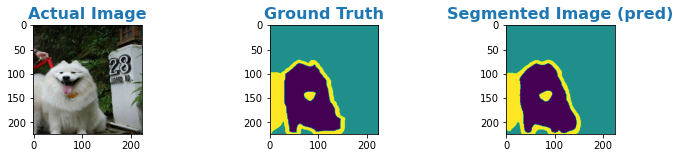

115/115 [==============================] - 98s 853ms/step - loss: 0.5397 - 1hot_iou: 0.1577 - val_loss: 0.2937 - val_1hot_iou: 0.1009
Epoch 84/100
115/115 [==============================] - ETA: 0s - loss: 0.5388 - 1hot_iou: 0.1578
Prediction after epoch #84


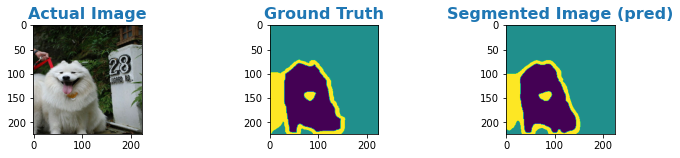

115/115 [==============================] - 98s 853ms/step - loss: 0.5388 - 1hot_iou: 0.1578 - val_loss: 0.3014 - val_1hot_iou: 0.0978
Epoch 85/100
115/115 [==============================] - ETA: 0s - loss: 0.5376 - 1hot_iou: 0.1578
Prediction after epoch #85


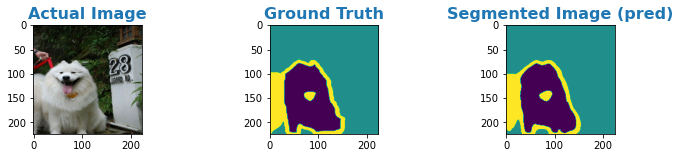

115/115 [==============================] - 98s 853ms/step - loss: 0.5376 - 1hot_iou: 0.1578 - val_loss: 0.3010 - val_1hot_iou: 0.0987
Epoch 86/100
115/115 [==============================] - ETA: 0s - loss: 0.5367 - 1hot_iou: 0.1578
Prediction after epoch #86


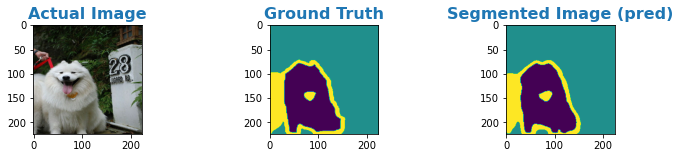

115/115 [==============================] - 98s 854ms/step - loss: 0.5367 - 1hot_iou: 0.1578 - val_loss: 0.2994 - val_1hot_iou: 0.0981
Epoch 87/100
115/115 [==============================] - ETA: 0s - loss: 0.5354 - 1hot_iou: 0.1578
Prediction after epoch #87


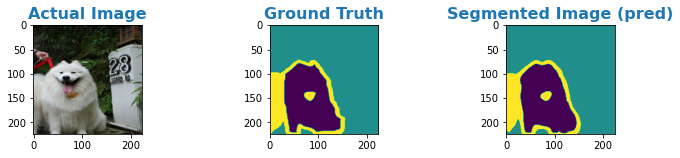

115/115 [==============================] - 98s 854ms/step - loss: 0.5354 - 1hot_iou: 0.1578 - val_loss: 0.2945 - val_1hot_iou: 0.1012
Epoch 88/100
115/115 [==============================] - ETA: 0s - loss: 0.5346 - 1hot_iou: 0.1578
Prediction after epoch #88


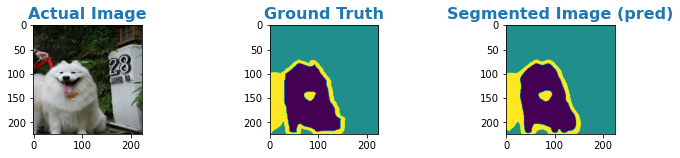

115/115 [==============================] - 98s 852ms/step - loss: 0.5346 - 1hot_iou: 0.1578 - val_loss: 0.2907 - val_1hot_iou: 0.0988
Epoch 89/100
115/115 [==============================] - ETA: 0s - loss: 0.5338 - 1hot_iou: 0.1578
Prediction after epoch #89


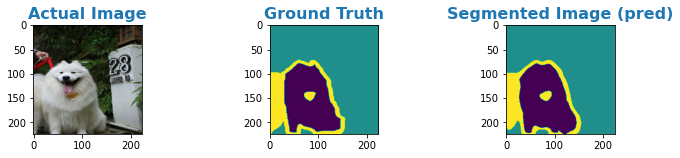

115/115 [==============================] - 98s 853ms/step - loss: 0.5338 - 1hot_iou: 0.1578 - val_loss: 0.2856 - val_1hot_iou: 0.1009
Epoch 90/100
115/115 [==============================] - ETA: 0s - loss: 0.5325 - 1hot_iou: 0.1578
Prediction after epoch #90


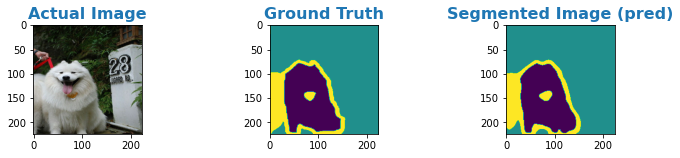

115/115 [==============================] - 98s 853ms/step - loss: 0.5325 - 1hot_iou: 0.1578 - val_loss: 0.3016 - val_1hot_iou: 0.0975
Epoch 91/100
115/115 [==============================] - ETA: 0s - loss: 0.5314 - 1hot_iou: 0.1578
Prediction after epoch #91


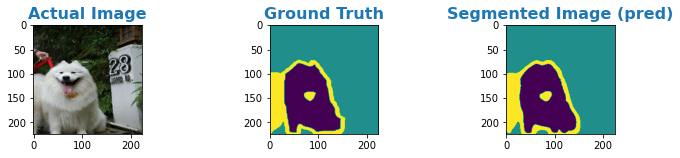

115/115 [==============================] - 98s 857ms/step - loss: 0.5314 - 1hot_iou: 0.1578 - val_loss: 0.3024 - val_1hot_iou: 0.0984
Epoch 92/100
115/115 [==============================] - ETA: 0s - loss: 0.5307 - 1hot_iou: 0.1578
Prediction after epoch #92


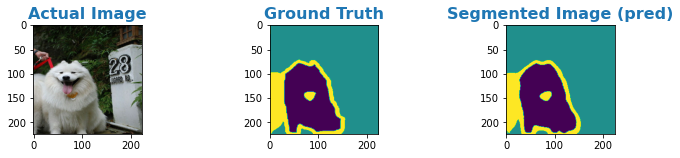

115/115 [==============================] - 98s 853ms/step - loss: 0.5307 - 1hot_iou: 0.1578 - val_loss: 0.2900 - val_1hot_iou: 0.1003
Epoch 93/100
115/115 [==============================] - ETA: 0s - loss: 0.5296 - 1hot_iou: 0.1578
Prediction after epoch #93


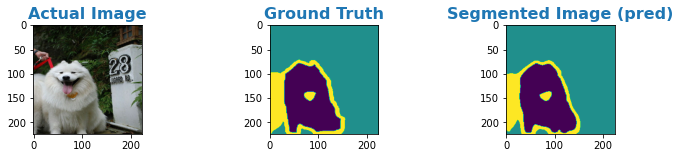

115/115 [==============================] - 98s 854ms/step - loss: 0.5296 - 1hot_iou: 0.1578 - val_loss: 0.2992 - val_1hot_iou: 0.1008
Epoch 94/100
115/115 [==============================] - ETA: 0s - loss: 0.5295 - 1hot_iou: 0.1578
Prediction after epoch #94


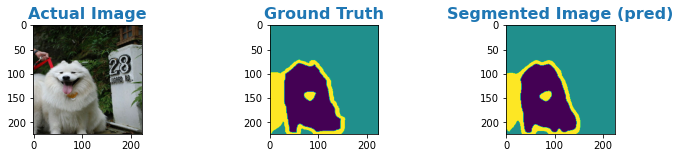

115/115 [==============================] - 98s 853ms/step - loss: 0.5295 - 1hot_iou: 0.1578 - val_loss: 0.2999 - val_1hot_iou: 0.0988
Epoch 95/100
115/115 [==============================] - ETA: 0s - loss: 0.5275 - 1hot_iou: 0.1579
Prediction after epoch #95


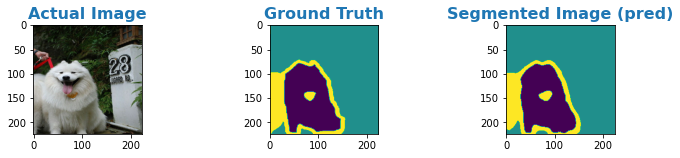

115/115 [==============================] - 98s 854ms/step - loss: 0.5275 - 1hot_iou: 0.1579 - val_loss: 0.2987 - val_1hot_iou: 0.0968
Epoch 96/100
115/115 [==============================] - ETA: 0s - loss: 0.5268 - 1hot_iou: 0.1579
Prediction after epoch #96


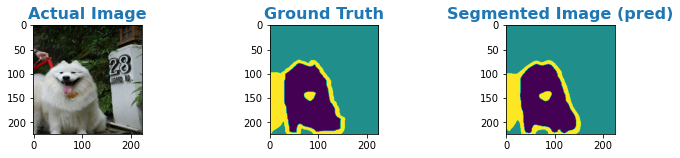

115/115 [==============================] - 98s 853ms/step - loss: 0.5268 - 1hot_iou: 0.1579 - val_loss: 0.2934 - val_1hot_iou: 0.0992
Epoch 97/100
115/115 [==============================] - ETA: 0s - loss: 0.5257 - 1hot_iou: 0.1579
Prediction after epoch #97


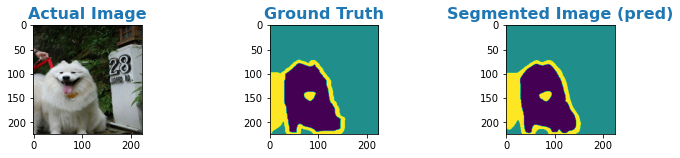

115/115 [==============================] - 98s 854ms/step - loss: 0.5257 - 1hot_iou: 0.1579 - val_loss: 0.2990 - val_1hot_iou: 0.0986
Epoch 98/100
115/115 [==============================] - ETA: 0s - loss: 0.5252 - 1hot_iou: 0.1579
Prediction after epoch #98


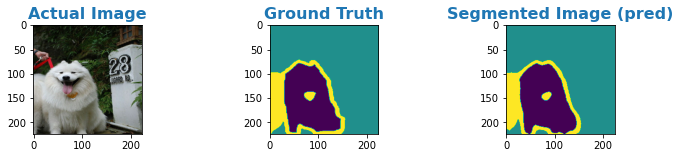

115/115 [==============================] - 98s 853ms/step - loss: 0.5252 - 1hot_iou: 0.1579 - val_loss: 0.2895 - val_1hot_iou: 0.1007
Epoch 99/100
115/115 [==============================] - ETA: 0s - loss: 0.5240 - 1hot_iou: 0.1579
Prediction after epoch #99


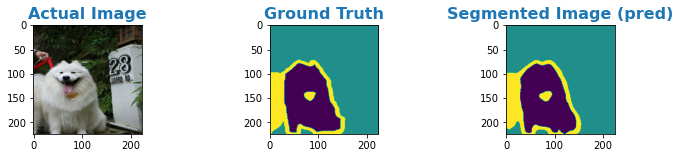

115/115 [==============================] - 98s 854ms/step - loss: 0.5240 - 1hot_iou: 0.1579 - val_loss: 0.2941 - val_1hot_iou: 0.0983
Epoch 100/100
115/115 [==============================] - ETA: 0s - loss: 0.5232 - 1hot_iou: 0.1579
Prediction after epoch #100


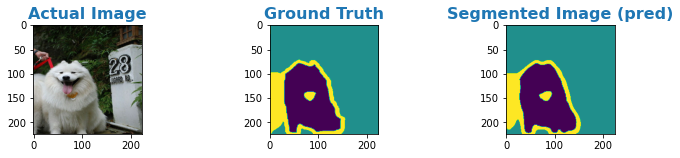

115/115 [==============================] - 98s 852ms/step - loss: 0.5232 - 1hot_iou: 0.1579 - val_loss: 0.2896 - val_1hot_iou: 0.1002


In [12]:
sample_image, sample_segmentation_mask = None, None
for smple_image, smple_segmentation_mask in ds_train_f64.take(1):
    sample_image, sample_segmentation_mask = smple_image, smple_segmentation_mask


class ShowPredictionsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'\nPrediction after epoch #{epoch + 1}')
        show_predictions(model, sample_image, sample_segmentation_mask, figsize=(12, 2))


print('Prediction before training')
show_predictions(model, sample_image, sample_segmentation_mask, figsize=(12, 2))
history = model.fit(ds_train_f64, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=ds_test_f64, callbacks=[ShowPredictionsCallback()])

## IoU and Loss diagrams
Copied from first homework

In [17]:
def plotHistory(hist, histDotted, histLabel, histDottedLabel, ylabel, title='', color='', index=0):
    def adjust_lightness(color, amount=1.7):
        try:
            c = mcolors.cnames[color]
        except:
            c = color
        
        if c is None or (isinstance(c, str) and c == ''):
            return ''
        
        c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
    if index > 0:
        plt.subplot(1, 2, index)
    
    # Smooth the line using gaussian blur
    lastValBeforeSmooth = hist[-1]
    hist = gaussian_filter1d(hist, sigma=1.2)
    histDotted = gaussian_filter1d(histDotted, sigma=1.2)
    plt.plot(histDotted, '.--', c=adjust_lightness(color), label=histDottedLabel)
    plt.plot(hist, '.-', c=color, label=histLabel)
    plt.ylim([0, max(np.max(hist), np.max(histDotted)) + 0.1])
    plt.title(title + ' {:.4f}'.format(lastValBeforeSmooth), fontsize=26, color='tab:blue')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend()
    plt.grid()


def plotIoUAndLoss(history):
    # Plot accuracy
    accuracyData = history.history['1hot_iou']
    valAccuracyData = history.history['val_1hot_iou']
    lossData = history.history['loss']
    valLossData = history.history['val_loss']
    
    fig = plt.figure(figsize=(20, 8))
    plotHistory(valAccuracyData, accuracyData, 'validation', 'training', ylabel='1-hot IoU', title='1-hot IoU:', color='tab:blue', index=1)
    plotHistory(valLossData, lossData, 'validation', 'training', ylabel='Loss', title='Loss:', color='tab:red', index=2)

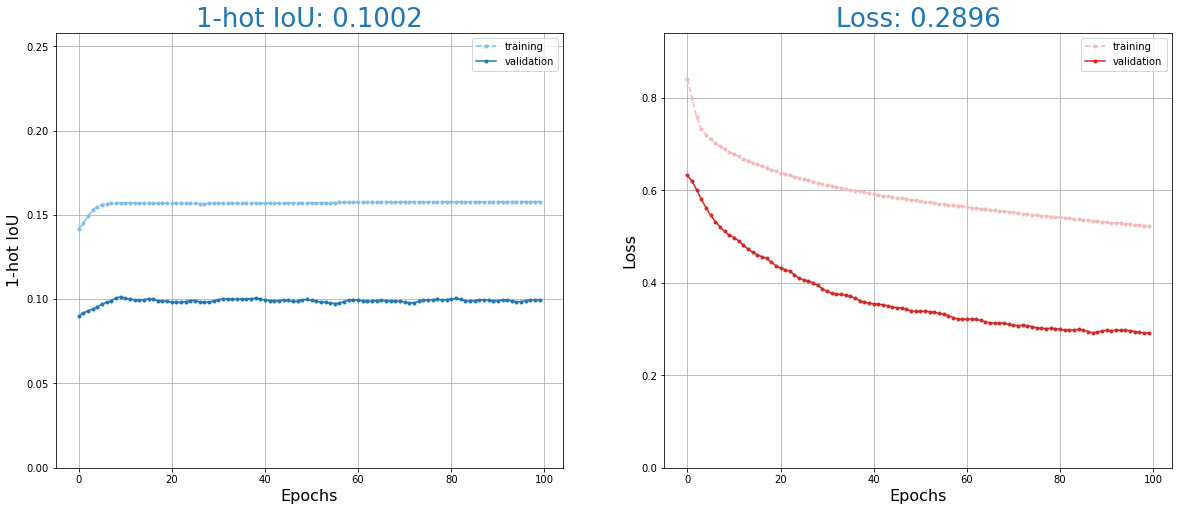

In [18]:
plotIoUAndLoss(history)

## Visualize some samples from train dataset
Train dataset is augmented

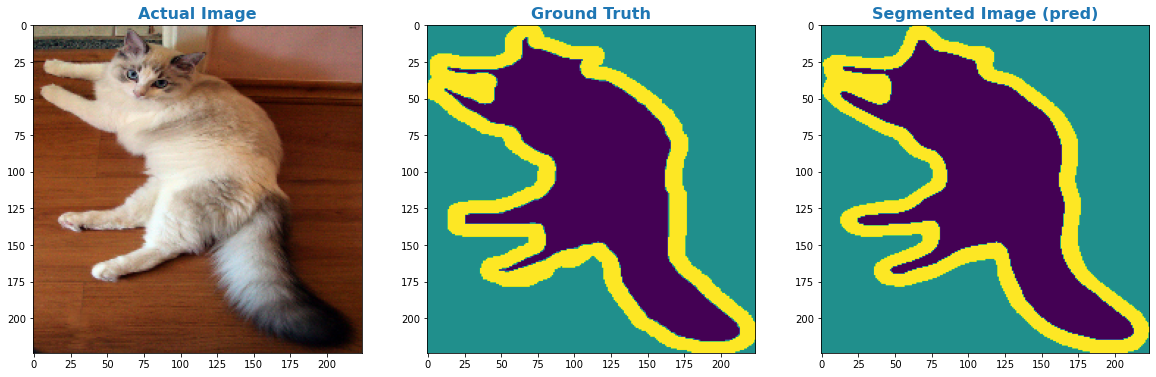

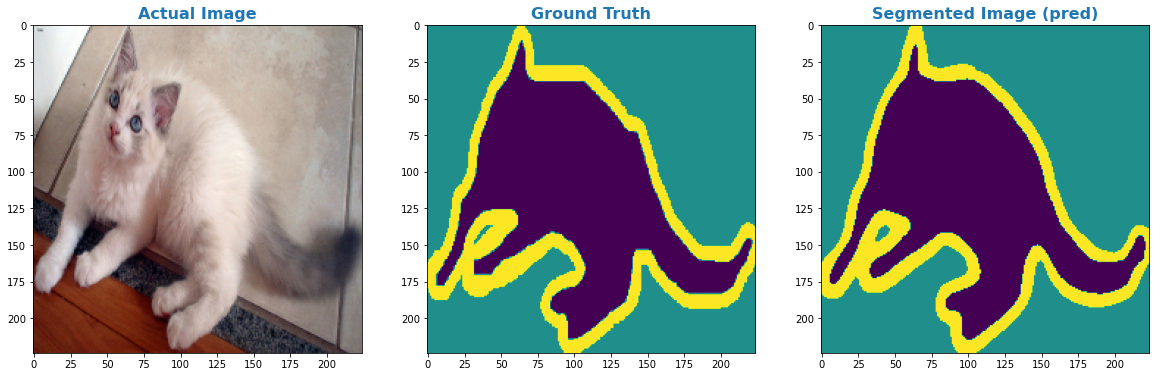

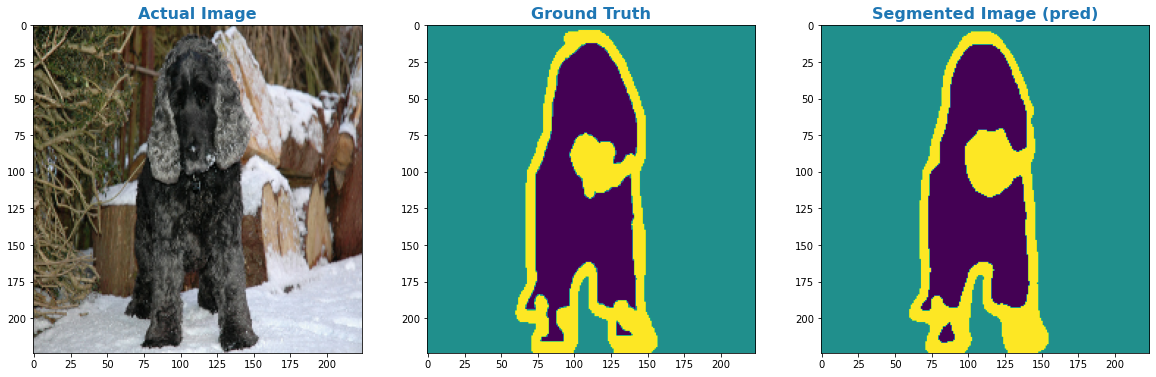

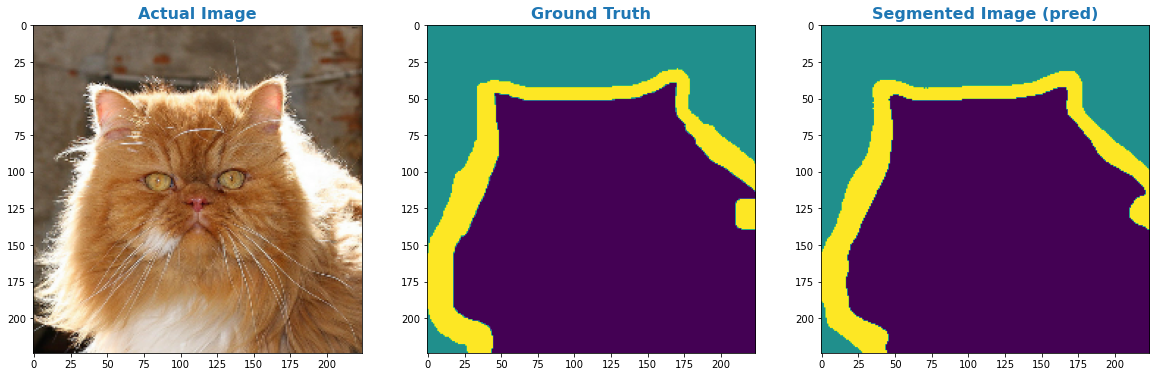

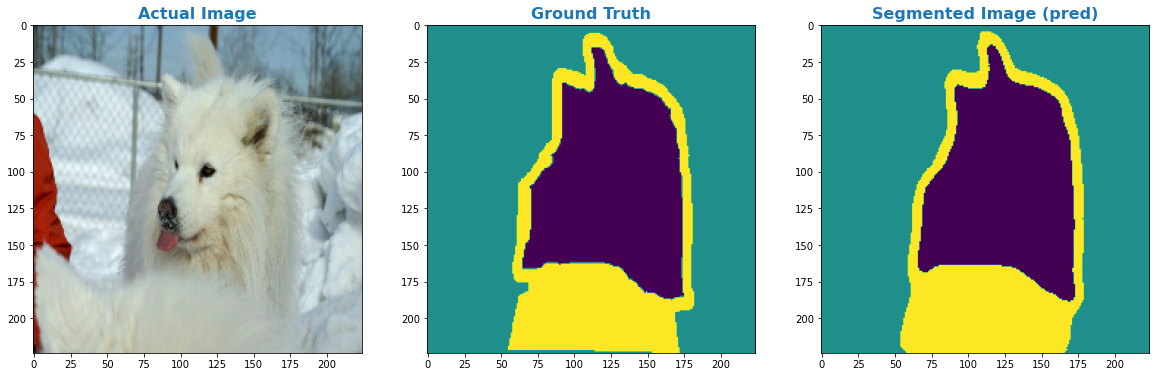

In [13]:
for sample_image, sample_segmentation_mask in ds_train_f64.take(5):
    show_predictions(model, sample_image, sample_segmentation_mask)

## Visualize some samples from validation dataset
Validation dataset is not augmented

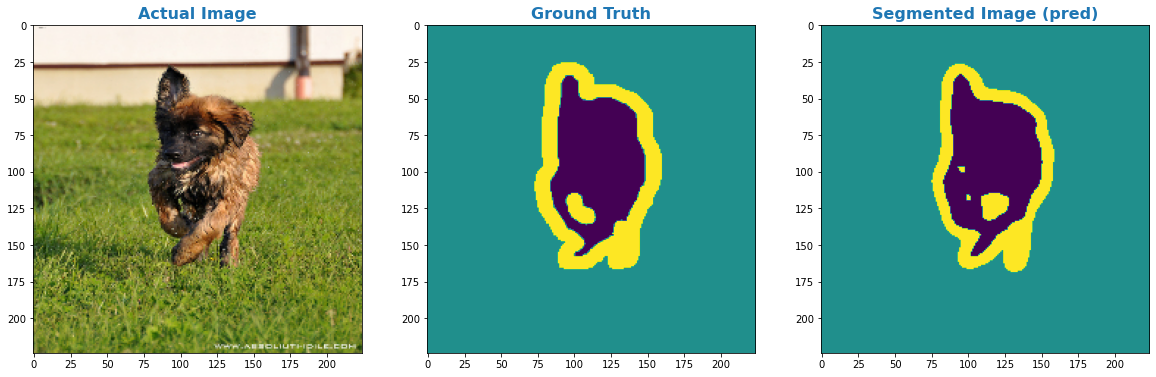

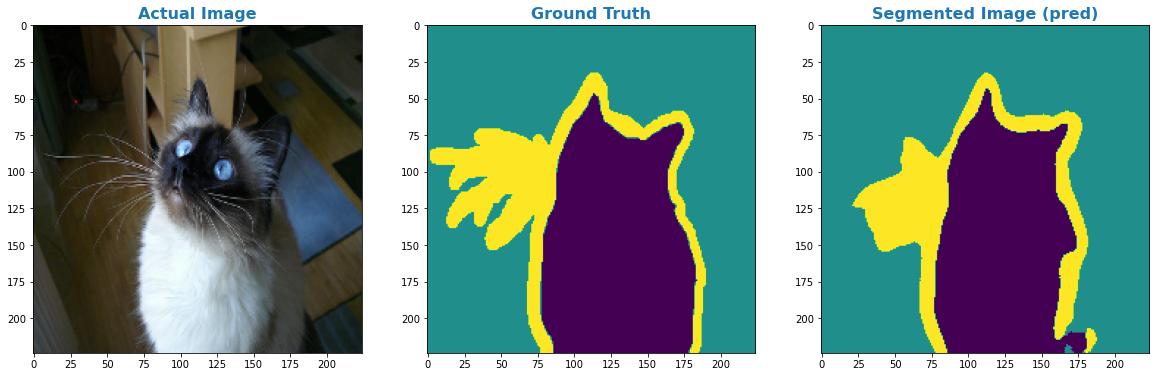

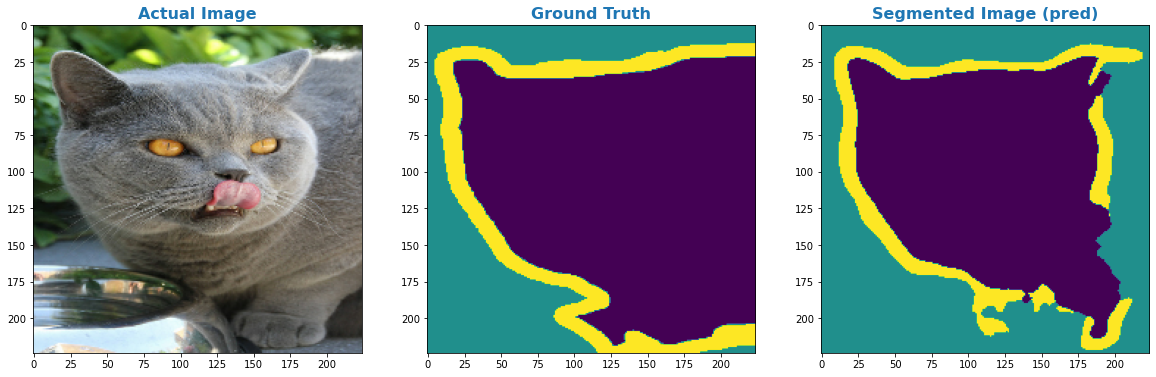

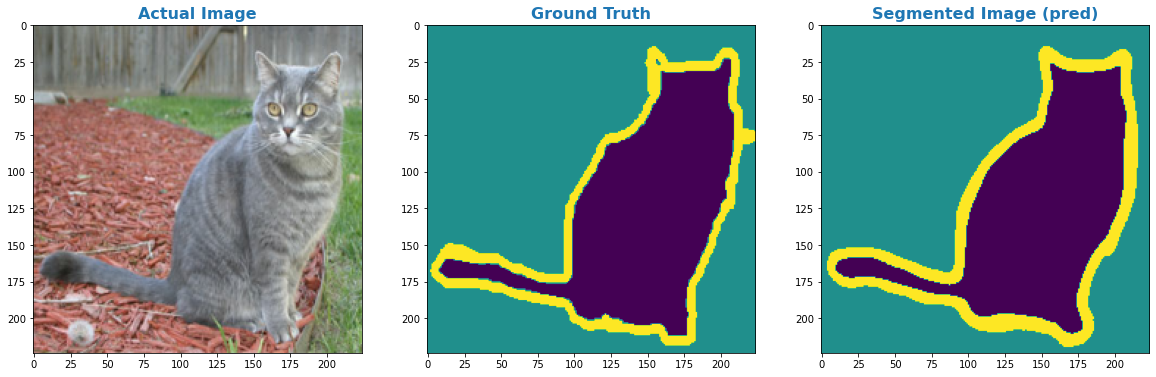

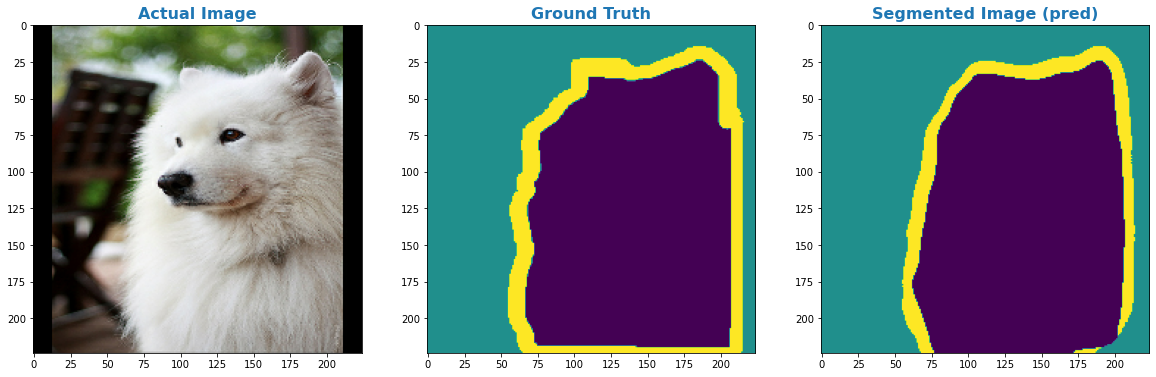

In [14]:
for sample_image, sample_segmentation_mask in ds_test_f64.take(5):
    show_predictions(model, sample_image, sample_segmentation_mask)